In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
"""
# oe_bls_cex_pumd
## Overview
---

The Consumer Expenditure Survey represents national estimates based upon two original
data collections: a Quarterly Interview Survey (Interview) and a Diary Survey (Diary).
Ensuring confidentiality prohibits publication of all, identifiable data inputs.
However, the BLS shares a sizeable sample of these sources, anonymized, called Public 
Use Microdata (PUMD).

## Concepts & Glossary

The Interview data has quarterly observations on each CU, while the Diary data is 
collected online bi-weekly.  So the PUMD datasets include a NEWID key that is the CU
identifier (CUID) suffixed by the observation. For interview data, the last digit 
ranges quarters (1,2,3,4) and for diary entries ranges biweek (1,2).

The PUMD includes a dimension of population density. First, CUs are split into Urban
vs Outside Urban. Urban CUs are then split into includes a categorical variable called
**popsize** or "Population Size Area" (PSA) which yields:
- Outside urban area
- All urban consumer units
- Less than 100,000
- 100,000 to 249,999
- 250,000 to 999,999
- 1,000,000 to 2,499,999
- 2,500,000 to 4,999,999
- 5,000,000 and more

The PUMD is published as sets of SAS, STAT or csv files.
This processing uses the csv file format.

The lowest level of detail collected in the PUMD is assigned a Universal
Classification Code (UCC), a six digit string left padded with zeros. The
BLS also uses these categories of spending for its Consumer Price Inflation (CPI)
publication.

For the PUMD, the UCC details are aggregated in to tree of subtotalling variables,
in a stucture called the hierarchical grouping (HG). The HG has three forms for the 
Interview, Diary and 'Integrated' view of the PUMD data. The lowest level nodes on the
HG are UCCs themselves. For example, the UCCs for cookies ('020510') and crackers 
('20610') are subtotaled to the variable "CRAKCOOK". 

At the highest level, the HG sums into four sections:
- Consumer unit characteristics like number of people, age of the reference person
- Demographics like race, ethnicity, education
- Incomes and Taxes
- Spending (finally) also called Average Annual Expenditures
This last, largest group of variables has its first level of detail such as Food,
Housing, Transportation and Health care.

The PUMD data is distributed by year, in quarterly files that have one of these formats:
  Diary Files
    FMLD - characteristics, income, weights, and summary level expenditures for the CU.
    MEMD - characteristics and income for each member in the CU.
    EXPD - a detailed weekly expenditure file categorized by UCC.
    DTBD - a detailed annual income file categorized by UCC.
    DTID - a Consumer Unit imputed income file categorized by UCC.
  Interview Files
    FMLI - characteristics, income, weights, and summary level expenditures for the CU.
    MEMI - characteristics and income for each member in the CU.
    MTBI - a detailed monthly expenditure file categorized by UCC.
    ITBI - a Consumer Unit monthly income file categorized by UCC.
    ITII - a Consumer Unit monthly imputed income file categorized by UCC.4
    NTAXI - a file with federal and state tax information for each tax unit in the CU.5

While these are many, the BLS shares some programming that focuses on just four. The
'family' data are keyed by Consumer Unit (CU) from each of the interview and diary sets
(FMLI & FMLD).  The UCC level spending details are found in (EXPD & MTBI)

The Survey intends to estimate the national population so summing across CUs should
reflects *weighting* where each CU represents a different fraction of the total pop. 

(to complicate things) 
Rather than one weight for each CU, the Survey uses Balanced Repeated Replication (BRR),
where the weight is re-estimated 45 times. The column named "FINLWTyy" is the final weight
for that yy year across weighting attempts (WTREP1-44).  Then, each attempt to estimate
population (REPWT) and cost (RCOST) and cost/pop and c/p per UCC has to reflect the 45
original weighting attempts.

Why not use the FINLWTyy to get single estimates of each?!

    pumdfiles: a dictionary, by year, with the file based dataframes
    hg: the Hierarchical Grouping table with linenum, level, title, survey, factor.
    vardict: provides a dictionary of the variables (not UCCs) in the PUMD
    codedict: provides a table with a description for each coded value in the PUMD
    
    The processing logic replicates what the BLS' own SAS (& R) program does!
    See:    https://www.bls.gov/cex/pumd-getting-started-guide.htm
            https://www.bls.gov/cex/pumd/sas-ucc.zip
            https://www.bls.gov/cex/pumd/r-ucc.zip
            
    This is also helpful 
            https://www.bls.gov/cex/pumd_doc.htm
            https://www.bls.gov/cex/csxintvw.pdf
            https://www.ilo.org/surveyLib/index.php/catalog/1193/download/8310


---
## Bugs & Issues
- One year has two columns were lowercase
- In 2018, vars were renamed


---
## Citations
Public Use Microdata (PUMD) https://www.bls.gov/cex/pumd_data.htm
U.S. Department of Labor, Bureau of Labor Statistics, Consumer Expenditure Survey, 
  Interview Survey, 2013.
https://www.bls.gov/cpi/additional-resources/geographic-sample.htm
"""

import pandas as pd
import numpy as np
from datetime import datetime
import wget
import zipfile
import os
import warnings
warnings.simplefilter("ignore")

def oe_bls_cex_pumd_download(years, pumddir = './pumd/', cexurl='https://www.bls.gov/cex/'):
    """
    This function downloads the files, dictionaries and hierarchical groupings of in
    Bureau of Labor Statistics (BLS), Consumer Expenditure Survey's (CEX) Public Use 
    Microsample Data (PUMD). Adjustments and corrections to this source are applied by
    the related oe_bls_cex_pumd_read function.
        
    :param  years:    a list of 4 digit years that are strings like ['2018','2019','2020'] 
    :param  pumddir:  a string with the path destination of the download & unzipped files 
    :param  cexurl:   the root URL for the Consumer Expenditure Survey

    :return None   The function either succeeds or fails
    """
    
    # Avoid conflicts with any previously downloaded
    if os.path.exists(pumddir):
        print("Destination directory '"+pumddir+"already exists.")
        print("Please remove it or select a new destination directory.")
        raise
    else:
        os.mkdir(pumddir)

    # Download and reformat the HGs as a dictionary of dataframes
    for yr in years:
        for fn in ('diary','intrvw'):
            # download
            print('Downloading',yr,fn)
            wget.download(cexurl+'pumd/data/comma/'+fn+yr[2:]+'.zip',
                          out=pumddir,
                          bar=None)
            # unzip
            with zipfile.ZipFile(pumddir+fn+yr[2:]+'.zip', 'r') as zip_ref:
                zip_ref.extractall(pumddir)
            
    # also need the HG file.  It is a zip of all years.
    print('Downloading Hierarchical Grouping file')
    wget.download(CEXURL+'pumd/stubs.zip', 
                  out=PUMDDIR,
                  bar=None)
    with zipfile.ZipFile(PUMDDIR+'stubs.zip', 'r') as zip_ref:
        zip_ref.extractall(PUMDDIR)

    # Get the PUMD dictionary
    print('Getting the PUMD dictionary')
    wget.download(CEXURL+'pumd/ce_pumd_interview_diary_dictionary.xlsx',
                  out=PUMDDIR,
                  bar=None)

    return None

def oe_bls_cex_pumd_read(years, pumddir = './pumd/', weights=False):
    """
    This function reads the PUMD data files of the dataset into python data structures. 

    :param  years: a list of 4 digit years that are strings     ['2018','2019','2020'] 
    :param  UCCs: a list of UCCs, six digit as strings     ['123456','234567','345678']

    pumdfiles: a dictionary, by year, with the file based dataframes
    hg: the Hierarchical Grouping table with linenum, level, title, survey, factor.
    vardict: provides a dictionary of the variables (not UCCs) in the PUMD
    codedict: provides a table with a description for each coded value in the PUMD

    :return  pumdfiles, hg, vardict, codedict
    """
    
    filetypes = ['dtbd','dtid','expd','fmld','memd','fmli','itbi','itii','memi','mtbi','ntax']

    filereads = {}
    for t in filetypes:
        filereads[t] = []

    for yr in years:
        for fn in ('diary','intrvw'):
            print("Reading",yr,fn)
            # Sometimes the intrv folder is in another subdir  intrvw17/intrvw17/*.csv eg
            if ((fn == 'intrvw') & (os.path.exists(pumddir+fn+yr[-2:]+ "\\"+fn+yr[-2:]+"\\"))):
                folder = fn+yr[-2:]+ "\\"+fn+yr[-2:]+"\\"
            else:
                folder = fn+yr[-2:]+ "\\"
            for f in os.listdir(pumddir+folder):
                ftype = f[0:4]
                if ftype in filetypes:
                    fdf = pd.read_csv(pumddir+folder +f, dtype=object)
                    fdf.columns = [c.upper() for c in fdf.columns]
                    fdf["filename"] = f
                    fdf["year"] = yr
                    filereads[ftype].append(fdf)

        # Ensure that the yearly versions have the same column names
        for t in filetypes:
            for f in filereads[t]:
                if list(f.columns).sort() != list(filereads[t][0].columns).sort():
                    print("Columns inconsistent",t)
            
        pumd = {}
        for t in filetypes:
            pumd[t] = pd.concat(filereads[t])   
    
    print('Reading the Hierarchical Groupings')
    # I'll use the Integrated HG.  Its mostly a superset of Interview & Diary HG less a dozen each
    hg = {}
    hgdtypes = {"linenum":int, "level":str, "title":str, "ucc":str, "survey":str, "factor":str, "group":str}
    for yr in years:
        h = pd.read_fwf(PUMDDIR+'stubs\\CE-HG-Integ-'+yr+'.txt', index_col=False,
        names =    ["linenum", "level",  "title",     "ucc",     "survey",  "factor",  "group"],
        colspecs = [(0, 3),     (3, 6),  (6, 69),  (69, 77),     (82, 85),  (85, 88),  (88,95)],
        dtype=hgdtypes)    
        # Rows with linenum == 2 are just title text that wrapped from the previous row.
        for i,r in h.iterrows():
            if r.linenum == 2:
                h.at[i-1,'title'] = h.at[i-1,'title']+' '+r.title
        hg[yr] = h[h.linenum == 1]
     
    print('Reading the Dictionary')
    # The sheet names can varyin capitalization and include spaces
    xl = pd.ExcelFile(PUMDDIR + 'ce_pumd_interview_diary_dictionary.xlsx')
    varsheet =  [c for c in xl.sheet_names if 'vari' in c.lower()][0]
    codesheet = [c for c in xl.sheet_names if 'code' in c.lower()][0]

    vardict =   pd.read_excel(PUMDDIR + 'ce_pumd_interview_diary_dictionary.xlsx',
                              sheet_name = varsheet)
    codedict =  pd.read_excel(PUMDDIR + 'ce_pumd_interview_diary_dictionary.xlsx',
                              sheet_name = codesheet)

    # filter the vardict sheet to only those where 
    #     you year of interest is > First Year > First Quart and < Last Year <Last Quarter

    return  pumd, hg, vardict, codedict


def oe_bls_cex_pumd_interpret(pumd, vardict, year, weights=False):
    """
    This function applies adjustments, logical rules and corrections to this source
    are applied by the related oe_bls_cex_pumd_read function.to PUMD data structures. 

    :param  years: a list of 4 digit years that are strings     ['2018','2019','2020'] 
    :param  UCCs: a list of UCCs, six digit as strings     ['123456','234567','345678']

    pumdfiles: a dictionary, by year, with the file based dataframes
    hg: the Hierarchical Grouping table with linenum, level, title, survey, factor.
    vardict: provides a dictionary of the variables (not UCCs) in the PUMD
    codedict: provides a table with a description for each coded value in the PUMD
    
    The processing logic replicates what the BLS' own SAS (& R) program does!
    See:    https://www.bls.gov/cex/pumd-getting-started-guide.htm
            https://www.bls.gov/cex/pumd-getting-started-guide.htm#section5
            https://www.bls.gov/cex/pumd/sas-ucc.zip
            https://www.bls.gov/cex/pumd/r-ucc.zip
            
    This is also helpful 
            https://www.bls.gov/cex/pumd_doc.htm
            https://www.bls.gov/cex/csxintvw.pdf
            https://www.ilo.org/surveyLib/index.php/catalog/1193/download/8310
            
    :return family:  a dataframe keyed by CU (NEWID) 
    :return expend:  a dataframe keyed by CU & UCC 
    :return pubfile: a join between family, expend 
    """

    print("Processing PUMD for", year)

    # Get family dataframes for Interview and Diary
    fmli = pumd['fmli'][pumd['fmli'].year == year]
    fmld = pumd['fmld'][pumd['fmld'].year == year]
    # Get member level dataframes
    mtbi = pumd['mtbi'][pumd['mtbi'].year == year]
    expd = pumd['expd'][pumd['expd'].year == year]

    # column name lists
    wtrep = [("WTREP"+str(i+1).zfill(2)) for i in range(44)]+["FINLWT21"] ## WTREP01-REPWT444 and FINL
    repwt = [("REPWT"+str(i+1)) for i in range(45)]  # REPWT1-REPWT45
    rcost = [("RCOST"+str(i+1)) for i in range(45)]  # RCOST1-RCOST45

    # Process Family

    fmli["source_family"] = 'I'

    # Sometimes QINT dates are meaningless, drop these 
    fmli = fmli.where(~fmli.QINTRVMO.isna())
    fmli = fmli.where(~fmli.QINTRVYR.isna())
    
    def mo_scope(row):
        if   (row["QINTRVMO"] in ['01','02','03']) & (row["QINTRVYR"]==year):
            return (int(row["QINTRVMO"]) - 1)
        elif (row["QINTRVMO"] in ['01','02','03']) & (row["QINTRVYR"]==str(int(year)+1)):
            return (4 - int(row["QINTRVMO"]))
        else:
            return 3

    fmli['mo_scope'] = fmli.apply(mo_scope, axis=1)
    
    fmld["source_family"] = "D"
    fmld["mo_scope"] = 3
    
    if weights:
        for i in range(45):
            fmli[wtrep[i]] = fmli[wtrep[i]].astype(float).fillna(0)
            fmli[repwt[i]] = (fmli[wtrep[i]] * fmli["mo_scope"]) / 12
            fmld[wtrep[i]] = fmld[wtrep[i]].astype(float).fillna(0)    
            fmld[repwt[i]] = (fmld[wtrep[i]] * fmld["mo_scope"]) / 12
    else:
        fmli['repwt'] = (fmli["FINLWT21"].astype(float).fillna(0) * fmli["mo_scope"]) / 12
        fmld['repwt'] = (fmld["FINLWT21"].astype(float).fillna(0) * fmld["mo_scope"]) / 12

    fmli = fmli.reset_index(drop=True)
    fmld = fmld.reset_index(drop=True)
    fmlcols = [c for c in fmli.columns if c in fmld.columns] # 272 columns
    if weights:
        fmlcols = [c for c in fmli.columns if c in wtrep[:-1]]
    family = pd.concat([fmli[fmlcols],fmld[fmlcols]], axis=0)

    # Process flag fields   _ values of A,B,C are NAs
    print("Processing flag fields")
    def flag_NAs(row,flagged,flagcol):
        if row[flagcol] in ["A","B","C"]:
            return np.NaN
        else:
            return row[flagged]
        return None

    flags = {}
    flag_candidates = vardict[["Variable Name","Flag name"]][~vardict["Flag name"].isna()].drop_duplicates()
    for i,r in flag_candidates.iterrows():
        if (r["Variable Name"] in family.columns) & (r["Flag name"] in family.columns):
            flags[r["Variable Name"]] = r["Flag name"]

    for col in flags.keys():
        # print("    ",col,"flagged by",flags[col])
        family[col] = family.apply(lambda row: flag_NAs(row,col,flags[col]), axis=1)
    
    family.drop([c for c in flags.values()], axis=1, inplace=True)
    
    fmlcols = family.columns  # reset this list
        
    # Process Expend

    mtbi["source_expend"] = "I"
    mtbi = mtbi[(mtbi["REF_YR"] == year) & (mtbi["PUBFLAG"] == "2")]

    expd["source_expend"] = "D"
    expd["COST"] = pd.to_numeric(expd["COST"], errors='coerce')
    expd["COST"] = expd["COST"].astype(float).fillna(0) * 13
    expd = expd[expd["PUB_FLAG"] == "2"]

    expcols =['NEWID','source_expend','UCC','COST'] #,'REF_YR'
    expend = pd.concat([mtbi[expcols],expd[expcols]], axis=0)

    pubfile = pd.merge(family, expend, on='NEWID', how='inner')
    
    pubfile["COST"] = pubfile["COST"].astype(float).fillna(0)
    if weights:
        for i in range(45):
            pubfile[rcost[i]] = pubfile[wtrep[i]] * pubfile["COST"]
    else:
        pubfile['rcost'] = pubfile["FINLWT21"].astype(float).fillna(0) * pubfile["COST"]

    #
    # Sum the raw data up to CUID
    #
    
    #pubfile.groupby(['CUID','UCC']).sum()[["COST","rcost"]].reset_index()
    temp = pubfile.groupby(['CUID','UCC']).sum()[["COST"]].reset_index()
    costs = temp.pivot(index="CUID",columns="UCC", values="COST").reset_index().fillna(0)
        
    #
    # Generate the summarization rules from HG
    #
    hg["level"] = hg["level"].astype(int)
    sumdict = {}
    sumrules = {}
    for level in [9,8,7,6,5,4,3,2]:
        for i,g in hg[hg.level.isin([level, level-1])].iterrows():        
            if g.level == level-1:
                rule = g.ucc
                sumdict[rule] = level-1
                sumrules[rule] = []
            else:
                sumrules[rule].append(g.ucc)

    emptyrules = [r for r in sumrules.keys() if len(sumrules[r]) == 0]
    for rule in emptyrules:
        sumrules.pop(rule)
        sumdict.pop(rule)

    # Test the rules
    for rule in sumrules.keys():
        if (len(sumrules[rule]) > 0) & (rule.isnumeric()):
            print('invalid rule',rule,': members but numeric')
        if (len(sumrules[rule]) == 0) & (not rule.isnumeric()):
            print('invalid rule',rule,': no members but not numeric')

    # Apply the rules from the bottom up
    rules = pd.DataFrame.from_dict({'name': list(sumdict.keys()), 'level': [sumdict[r] for r in sumdict.keys()]})
    for level in [9,8,7,6,5,4,3,2]:
        print("level",level)
        for i, rule in rules[rules.level == level-1].iterrows():
            costs[rule["name"]] = cex[sumrules[rule["name"]]].sum(axis=1)
        
    return pubfile, family, expend, fmli, fmld, mtbi, expd


def oe_bls_cex_pumd_metadata(hg,vd,cd,year):
    """
    This function interprets PUMD metadata objects, 
    selecting rows applicable to the selected year.
    
    :param hg: A dictionary by year of Hierarchical Grouping dataframes
    :param vd: The Variables dataframe from the PUMD Dictionary
    :param cd: The Codes dataframe from the PUMD Dictionary
    
    :return h,v,c: the current year dataframe of each of the parameters
    """
    print("Narrowing metadata to", year)
    
    # Interpret the Hierarchical Grouping

        # survey column:
        #    I: Interview survey
        #    D: Diary survey
        #    G and T: Titles
        #    S: Statistical UCCs

        # group column
        #    CUCHARS: CU characteristics
        #    FOOD: Food expenditures
        #    EXPEND: Non-food expenditures
        #    INCOME: Income types
        #    ASSETS: Asset types
        #    ADDENDA: Other financial information and gifts
    h = hg[year]
    
    # Interpret the Variable Dictionary
    # Final year is empty for current definitions
    vd["Last year"] = vd["Last year"].fillna(datetime.now().year+1)
    v = vd[(int(yr) >= vd["First year"] ) & (int(yr) <= vd["Last year"] )]
    
    # Interpret the Code Dictionary
    cd["Last year"] = cd["Last year"].fillna(datetime.now().year+1)
    c = cd[(int(yr) >= cd["First year"] ) & (int(yr) <= cd["Last year"] )]
    
    return h,v,c


def oe_bls_cex_pumd_check(df, year):
    """
    This function compares the interpreted PUMD results against
    MSA and State totals.
    """
    return True


def oe_bls_cex_pumd_write(df, year):
    """
    This function writes a final dataframe to file.
    """
    print("Writing to "+year+" blockgroupspending file")
    df.to_csv(year+'blockgroupspending.csv', index=False)
    return None


if __name__ == "__main__":
    
    # Capitalized variables are globals or multi-year storage
    # Lowercase variables are those for a given working year
    
    CEXURL = 'https://www.bls.gov/cex/'
    PUMDDIR = "D:\\Open Environments\\data\\bls\\cex\\pumd\\"
    YEARS = ['2018'] # ['2016','2017','2018','2019','2020']
    
    #oe_bls_cex_pumd_download(YEARS, pumddir = PUMDDIR, cexurl=CEXURL)
    
    PUMD, HG, VARDICT, CODEDICT = oe_bls_cex_pumd_read(YEARS, pumddir = PUMDDIR)
    
    for yr in YEARS: 
        hg, vardict, codedict    = oe_bls_cex_pumd_metadata(HG,VARDICT,CODEDICT,yr)
        pubfile, family, expend, fmli, fmld, mtbi, expd  = oe_bls_cex_pumd_interpret(PUMD,VARDICT,yr,weights=False)
        #oe_bls_cex_pumd_write(family,yr)

    # WTREP & REPWT   90 weighting columns

    # Geography:
    # family.PSU  is the primary sampling unit - for CEX that is an MSA!
    # CUs are intended to be weighted samples of an MSA
    #      An Metropolitan Statistical Area (MSA) is a subset of OMB's 
    #          Core Based Statistical Areas CBSA's
    #      Each MSA has a POPSIZE (the CU popsize is the MSA's replicated across CU records)
    #      Each MSA aggregates a group of counties (which can decompost into Census geogs)
    #          https://www.nber.org/research/data/census-core-based-statistical-area-cbsa-federal-information-processing-series-fips-county-crosswalk
    #      But BLS codes the MSAs using "CPI codes"  
    #          https://www.bls.gov/cpi/additional-resources/geographic-sample.htm
    #      National Bureau of Economic Research | NBER
    #          https://back.nber.org/appendix/c14245/replication/rawData/CPI%20MSA%20to%20Unemployment%20(OMB)%20MSA.xlsx
    #        
    # BOS Balance-of-State area codes are for areas in a US State that are OUTSIDE the major MSA
    # bls CPI Codes for MSA, bls QCEW survey codes the major MSAs with 
    # Office of Management and Budget
    #    these are repeated described as groups of counties
    #    so Block Groups can be married up to them
    # family.PSU.value_counts()
    #    S12A    2280
    #    S49A    1815
    #    S23A    1010
    #    S37A     704
    #    S35A     701

    # family.CUID identifies the household
    # family.NEWID identifies the data coll obs (several per household)
    # So:
    #    NEWID = "0" + CUID + [1,2,3,4] for quarterly interview or [1,2] for biweekly
    #    fmli.CUID.str.zfill(7) == fmli.NEWID.str[:-1]
    
    # family.FINLWT21
    
    # family.RACE_REF
        #1	White    32627
        #2	Black     4186
        #3	Native American      182
        #4	Asian     2083
        #5	Pacific Islander      127
        #6	Multi-race      656

    # family.STATE is FIPS codes of 40 states
    
    # family.POPSIZE
        #- 1	More than 5 million     8781
        #- 2	1-5 million    13917
        #- 3	0.5-1.0 million    4857
        #- 4	100-500 thousand     7971
        #- 5	Less than 100 thousand     4335

    # family.BLS_URBN  is related to POPSIZE, splitting level 4 and 5 into Urban Rural
        #        		BLS_URBN	1	2
        #    POPSIZE		
        #    	1					8781	0
        #    	2					13917	0
        #    	3					4857	0
        #    	4					7365	606
        #    	5					2269	2066

    # family.DIVISION
    states = pd.read_csv("https://raw.githubusercontent.com/OpenEnvironments/core/main/states.csv")
    divisions = states[['CensusDivisionName','CensusDivisionCode']].drop_duplicates().dropna()

    # family.MARITAL
        #1	Married    20730
        #2	Widowed     3770
        #3	Divorced     6133
        #4	Separated      911
        #5	Never married     8317
        
    # pubfile
    # Top Line Tables 2021 
    # https://www.bls.gov/cex/tables/calendar-year/mean/cu-all-multi-year-2021.pdf
    #     Number of CUs 133.595 million
    #     Income before taxes $87.432 m
    #     Income after taxes 78.743 m
    #     Race: African American or black 13%
    #     Hispanic or Latino: 15
    #     Educ of reference person 69 college
    #     Average annual expenditure $66,928 m   PER CU
    #
    #     Total spending CUs x Ave Annual = $8,941,246,160,000 

    # family.EDUC_REF
    #  46.7% have 14/15/16 college degree or greater
    #  00	Never attended                                   109
    #  10	Nursery, kindergarten, and elementary (grades 1-8)  1200
    #  11	High school (grades 9-12), no degree             2694
    #  12	High school graduate                             8880
    #  13	Some college, no degree                          8366
    #  14	Associate's degree in college                    4060
    #  15	Bachelors degree                                 9123
    #  16	Masters, professional or doctorate degree        5429
    
    # family.CUTENURE
    #   1	Owned w/mortgage                     14988
    #   2	Owned w/o mortgage                   10477 
    #   3	Owned mortgage NR                    210
    #   4	Rented                               13391
    #   5	Occupied w/o payment of cash rent    607
    #   6	Student housing                      188

    # family.CHILDAGE
    #    0	No children                                25266
    #    1	Oldest child less than 6                   2137
    #    2	Oldest child age 6-11 and at less one child less than 6       1374  
    #    3	All children age 6-11                      1448
    #    4	Oldest child age 12-17 and at less one child less than 12     1926
    #    5	All children age 12-17                       1963
    #    6	Oldest child age greater than 17 and at less one child less than 17   1569
    #    7	All children age greater than 17             25266

    
    # family.FAM_TYPE
    # 9522     1	Married Couple only
    # 1534     2	Married Couple, own children only, oldest child < 6           
    # 4431     3	Married Couple, own children only oldest child >= 6, <= 17
    # 2818     4	Married Couple, own children only, oldest child > 17
    # 1540     5	All other Husband and wife families
    #  394     6	One parent, male, own children at least one age < 18
    # 1583     7	One parent, female, own children, at least one age < 18
    # 12050    8	Single consumers
    # 5989     9	Other families   
    #
    # Corresponds to ACS
    #     Family = Married-couple vs Other family
    #
    # B11003e1 Families (basis)
        # B11003e2 Married-couple family
            # B11003e2 Married-couple family	With own children of the householder under 18 years
                # B11003e4 Married-couple family	With own children of the householder under 18 years	Under 6 years only
                # B11003e5 Married-couple family	With own children of the householder under 18 years	Under 6 years and 6 to 17 years
                # B11003e6 Married-couple family	With own children of the householder under 18 years	6 to 17 years only
            # B11003e7 Married-couple family	No own children of the householder under 18 years
    # B11003e8 Other family
        # B11003e9 Other family Male householder no spouse present
            # +  No own children, Own children under 18, Under 6, etc
        # B11003e15 Other family Female householder no spouse present
            # +  No own children, Own children under 18, Under 6, etc
        
        

    
    print("Done")

Reading 2018 diary
Reading 2018 intrvw
Reading the Hierarchical Groupings
Reading the Dictionary
Narrowing metadata to 2018
Processing PUMD for 2018
Processing flag fields
Done


In [26]:
len(q.CUID.unique())

19024

In [27]:
q.shape

(19024, 690)

In [7]:
set(pubfile.UCC.unique()) - set(hg.ucc.unique())

set()

In [10]:
hg.level.value_counts()

5    546
4    477
6    191
3    138
7     97
2     32
8     17
1     11
9      2
Name: level, dtype: int64

In [90]:
sum the records up to year by CU
    across quarters, sum biweek then x 26?
create a group by CU x UCC
transpose it UCC is columns




level 9
OWVMIS is sum ['320613', '990940']
level 8
OWNMIS is sum ['320612', '990930']
RNTMIS is sum ['320611', '990920', '790690']
OWVREP is sum ['240113', '240123', '240214', '240223', '240313', '240323', 'OWVMIS', '320633']
OWVMNA is sum ['230902', '340912']
level 7
BREAD is sum ['020110', '020210']
CRAKCO is sum ['020510', '020610']
OTHBAK is sum ['020310', '020410', '020620', '020710', '020820']
ROAST is sum ['030210', '030310', '030410']
STEAK is sum ['030510', '030610', '030710']
HAM is sum ['040310', '040610']
LNCHME is sum ['050210', '050310']
LAMBOT is sum ['050410', '050900']
CHICKE is sum ['060110', '060210']
FRZNFR is sum ['130110', '130121', '130122']
CANDVE is sum ['140210', '140220', '140230', '140320', '140330', '140340', '140310', '140410', '140420']
FRZNPR is sum ['180210', '180220']
SNACKS is sum ['180310', '180320']
CONDMN is sum ['180410', '180420', '180510', '180520']
OTHRPR is sum ['180611', '180612', '180620', '180710', '180720']
COFFEE is sum ['170310', '170410

In [70]:
sumrules

{'OWVMIS': ['320613', '990940'],
 'OWNMIS': ['320612', '990930'],
 'RNTMIS': ['320611', '990920', '790690'],
 'OWVREP': ['240113',
  '240123',
  '240214',
  '240223',
  '240313',
  '240323',
  'OWVMIS',
  '320633'],
 'OWVMNA': ['230902', '340912'],
 'BREAD': ['020110', '020210'],
 'CRAKCO': ['020510', '020610'],
 'OTHBAK': ['020310', '020410', '020620', '020710', '020820'],
 'ROAST': ['030210', '030310', '030410'],
 'STEAK': ['030510', '030610', '030710'],
 'HAM': ['040310', '040610'],
 'LNCHME': ['050210', '050310'],
 'LAMBOT': ['050410', '050900'],
 'CHICKE': ['060110', '060210'],
 'FRZNFR': ['130110', '130121', '130122'],
 'CANDVE': ['140210',
  '140220',
  '140230',
  '140320',
  '140330',
  '140340',
  '140310',
  '140410',
  '140420'],
 'FRZNPR': ['180210', '180220'],
 'SNACKS': ['180310', '180320'],
 'CONDMN': ['180410', '180420', '180510', '180520'],
 'OTHRPR': ['180611', '180612', '180620', '180710', '180720'],
 'COFFEE': ['170310', '170410'],
 'OWNREP': ['240112',
  '240122',

In [ ]:
recall that WTs are population counts to
    weight the CU level est to a national total
    WT = how many people does this observation represent?


CREATE TABLE POP AS
SELECT source, SUM(REPWT1) AS RPOP1 ... SUM(REPWT45) AS RPOP45
from pubfile
group by source.
;

# AGG is I/D, UCC
CREATE TABLE AGG AS
select source,UCC
  SUM(RCOST1-45)
group by source, UCC

CREATE TABLE AVGS1
	MERGE 	AGG, POP; 
	BY SOURCE; 
 	MEAN1-45 = (RCOST1-45 / RPOP1-45);

CREATE TABLE AVGS2
  select SUM(MEAN1-45)
  group by UCC

--------------------------------------------------------------------
so 
    POP   is I/D with population 1-45 across
    AGG	  is I/D with costs 1-45 across 
    AVGS1 is I/D with cost weights across

In [ ]:
/***************************************************************************/
  /* PROGRAM NAME:  CEX INTEGRATED SURVEYS SAMPLE PROGRAM (SAS)              */
  /* FUNCTION: CREATE A WEIGHTED CALENDAR YEAR AVERAGE EXPENDITURE           */
  /*           FOR A SPECIFIED GROUP OF UCC's                                */
  /*                                                                         */
  /*                                                                         */
  /***************************************************************************/

  /***************************************************************************/
  /* STEP1: SET PARAMETERS                                                   */
  /***************************************************************************/

  /*ENTER DATA YEAR*/
    %LET YEAR = 2018;
  /* ENTER SURVEY SOURCE FOR WHICH YOU WISH TO ESTIMATE FROM (INTERVIEW, DIARY, INTEGRATED)*/
	%LET ESTIMATE = INTEGRATED;
  /* ENTER THE UCCs YOU WISH TO ESTIMATE FOR*/
	%LET UCC = ('470111'); 
  /* ENTER A NAME FOR THE ESTIMATE BEING CREATED*/
	%LET AGG = GASOLINE;
 
	%LET YR1 = %SUBSTR(&YEAR, 3, 2);
	%LET YR2 = %SUBSTR(%EVAL(&YEAR + 1), 3, 2);
  /*ENTER LOCATION OF THE UNZIPPED MICRODATA FILE*/
    %LET DRIVE = C:\2018_CEX;

	LIBNAME I&YR1 "&DRIVE\INTRVW&YR1";
	LIBNAME D&YR1 "&DRIVE\DIARY&YR1";


  /***************************************************************************/
  /* STEP2: READ IN ALL NEEDED DATA                                          */
  /* ----------------------------------------------------------------------- */
  /* 1 READ IN THE INTERVIEW AND DIARY FMLY FILES & CREATE MO_SCOPE VARIABLE */
  /* 2 READ IN THE INTERVIEW MTAB/ITAB AND DIARY EXPN/DTAB FILES             */
  /* 3 MERGE FMLY AND EXPENDITURE FILES TO DERIVE WEIGHTED EXPENDITURES      */
  /***************************************************************************/


DATA FMLY (KEEP= NEWID QINTRVYR QINTRVMO WTREP01-WTREP44 FINLWT21 REPWT1-REPWT45 MO_SCOPE SOURCE);

SET D&YR1..FMLD&YR1.1 (IN = DIARY)
    D&YR1..FMLD&YR1.2 (IN = DIARY)
    D&YR1..FMLD&YR1.3 (IN = DIARY)
    D&YR1..FMLD&YR1.4 (IN = DIARY)

    I&YR1..FMLI&YR1.1x (IN = INTERVIEW)
    I&YR1..FMLI&YR1.2  (IN = INTERVIEW)
    I&YR1..FMLI&YR1.3  (IN = INTERVIEW)
    I&YR1..FMLI&YR1.4  (IN = INTERVIEW)
    I&YR1..FMLI&YR2.1  (IN = INTERVIEW);

	BY NEWID;

	ESTIMATE = "&ESTIMATE.";

	ARRAY REPS_A(45) WTREP01-WTREP44 FINLWT21;
    ARRAY REPS_B(45) REPWT1-REPWT45;

	IF INTERVIEW AND ESTIMATE IN ("INTERVIEW","INTEGRATED") THEN DO;
		SOURCE = 'I';
		IF QINTRVMO IN ('01','02','03') AND QINTRVYR = &YEAR. THEN MO_SCOPE = (QINTRVMO - 1);
    		ELSE IF QINTRVMO IN ('01','02','03') AND QINTRVYR = &YEAR. + 1 THEN MO_SCOPE = (4 - QINTRVMO);
    			ELSE MO_SCOPE = 3;

 		DO i = 1 TO 45;
	  	IF REPS_A(i) > 0 THEN REPS_B(i) = (REPS_A(i) * MO_SCOPE / 12);
		END;	
				OUTPUT;
				END;

	IF DIARY AND ESTIMATE IN ("DIARY","INTEGRATED") THEN DO;
		SOURCE = "D";
		MO_SCOPE = 3;

	DO i = 1 TO 45;
	  	IF REPS_A(i) > 0 THEN REPS_B(i) = (REPS_A(i) * MO_SCOPE / 12);
		END;	

				OUTPUT;
				END;

	
	  IF QINTRVYR  THEN 
        SOURCE = 'I';
	  IF WEEKI THEN 
        SOURCE = 'D';

RUN;

DATA EXPEND (KEEP= NEWID SOURCE UCC COST REF_YR);

  SET D&YR1..EXPD&YR1.1 (IN = DIARY)
      D&YR1..EXPD&YR1.2 (IN = DIARY)
      D&YR1..EXPD&YR1.3 (IN = DIARY)
      D&YR1..EXPD&YR1.4 (IN = DIARY)

      I&YR1..MTBI&YR1.1X (IN = INTERVIEW)
      I&YR1..MTBI&YR1.2  (IN = INTERVIEW)
      I&YR1..MTBI&YR1.3  (IN = INTERVIEW)
      I&YR1..MTBI&YR1.4  (IN = INTERVIEW)
      I&YR1..MTBI&YR2.1  (IN = INTERVIEW);
	
  ESTIMATE = "&ESTIMATE.";
  IF UCC IN &UCC.;       

	IF INTERVIEW AND ESTIMATE IN ("INTERVIEW") THEN DO;
		SOURCE = 'I';
		IF (REF_YR = "&YEAR") THEN
			OUTPUT;
			END;
	ELSE IF INTERVIEW AND ESTIMATE = "INTEGRATED" THEN DO; 
		SOURCE = "I"; 
		IF (REF_YR = "&YEAR");
		IF PUBFLAG = "2" THEN
 			OUTPUT;
			END;

	IF DIARY AND ESTIMATE IN ("DIARY") THEN DO;
		SOURCE = 'D';
		COST = COST * 13;
			OUTPUT;
			END;

	ELSE IF DIARY AND ESTIMATE IN ("INTEGRATED") THEN DO; 
		SOURCE = "D"; 
		COST = COST * 13;
		IF PUB_FLAG = "2" THEN
 			OUTPUT;
			END;
	
RUN;	

PROC SORT DATA=EXPEND;
	BY NEWID;
RUN;

DATA PUBFILE (KEEP= NEWID SOURCE UCC WTREP01-WTREP44 FINLWT21 RCOST1-RCOST45 REPWT1-REPWT45 MO_SCOPE COST);
  MERGE FMLY   (IN= INFAM)
        EXPEND (IN= INEXP);
  BY NEWID;
  IF (INEXP AND INFAM);

  IF (COST = .)  THEN 
     COST = 0;
     ARRAY REPS_A(45) WTREP01-WTREP44 FINLWT21;
     ARRAY REPS_B(45) RCOST1-RCOST45;

     DO i = 1 TO 45;
	   IF REPS_A(i) > 0
         THEN REPS_B(i) = (REPS_A(i) * COST);
	     ELSE REPS_B(i) = 0; 	
	 END; 

RUN;

  /***************************************************************************/
  /* STEP3: CALCULATE POPULATIONS                                            */
  /* ----------------------------------------------------------------------- */
  /*  SUM ALL 45 WEIGHT VARIABLES TO DERIVE REPLICATE POPULATIONS            */
  /*  FORMATS FOR CORRECT COLUMN CLASSIFICATIONS                             */
  /***************************************************************************/

PROC SUMMARY NWAY DATA=FMLY SUMSIZE=MAX;
  CLASS SOURCE / MLF;
  VAR REPWT1-REPWT45;
  OUTPUT OUT = POP (DROP = _TYPE_ _FREQ_) SUM = RPOP1-RPOP45;
RUN;

 

  /***************************************************************************/
  /* STEP4: CALCULATE WEIGHTED AGGREGATE EXPENDITURES                        */
  /* ----------------------------------------------------------------------- */
  /*  SUM THE 45 REPLICATE WEIGHTED EXPENDITURES TO DERIVE AGGREGATES/UCC    */
  /*  FORMATS FOR CORRECT COLUMN CLASSIFICATIONS                             */
  /***************************************************************************/


PROC SUMMARY NWAY DATA=PUBFILE SUMSIZE=MAX COMPLETETYPES;
  CLASS SOURCE UCC / MLF;
  VAR RCOST1-RCOST45;
  OUTPUT OUT= AGG (DROP= _TYPE_ _FREQ_) 
  SUM= RCOST1-RCOST45;
RUN;



  /***************************************************************************/
  /* STEP5: CALCULTATE MEAN EXPENDITURES                                     */
  /* ----------------------------------------------------------------------- */
  /* 1 READ IN POPULATIONS AND LOAD INTO MEMORY USING A 3 DIMENSIONAL ARRAY  */
  /*   POPULATIONS ARE ASSOCIATED BY INCLASS, SOURCE(t), AND REPLICATE(j)    */
  /* 2 READ IN AGGREGATE EXPENDITURES FROM AGG DATASET                       */
  /* 3 CALCULATE MEANS BY DIVIDING AGGREGATES BY CORRECT SOURCE POPULATIONS  */
  /*   EXPENDITURES SOURCED FROM DIARY ARE CALULATED USING DIARY POPULATIONS */
  /*   WHILE INTRVIEW EXPENDITURES USE INTERVIEW POPULATIONS                 */
  /* 4 SUM EXPENDITURE MEANS PER UCC INTO CORRECT LINE ITEM AGGREGATIONS     */
  /***************************************************************************/


DATA AVGS1 ;
	MERGE 	AGG
			POP; 
		BY SOURCE; 
		
	   		ARRAY REPS_A(45) RCOST1-RCOST45;
			ARRAY REPS_B(45) RPOP1-RPOP45;
			ARRAY REPS_C(45) MEAN1-MEAN45;
     		DO i = 1 TO 45;
	   	IF REPS_A(i) > 0
         THEN REPS_C(i) = (REPS_A(i) / REPS_B(i));
	     ELSE REPS_C(i) = .; 
		END;	
		RUN;


PROC SUMMARY DATA=AVGS1 NWAY COMPLETETYPES;
  CLASS UCC / MLF;
  VAR MEAN1-MEAN45;
  OUTPUT OUT=AVGS2 (DROP= _TYPE_ _FREQ_) SUM= ;
  /* SUM UCC MEANS TO CREATE AGGREGATION SCHEME */
RUN;

  /***************************************************************************/
  /* STEP6: CALCULTATE STANDARD ERRORS                                       */
  /* ----------------------------------------------------------------------- */
  /*  CALCULATE STANDARD ERRORS USING REPLICATE FORMULA                      */
  /***************************************************************************/

PROC SUMMARY DATA=AVGS1 NWAY COMPLETETYPES;
  VAR MEAN1-MEAN45;
  OUTPUT OUT=AVGS_SUM (DROP= _TYPE_ _FREQ_) SUM= ;
  /* SUM UCC MEANS TO CREATE AGGREGATION SCHEME */
RUN;

DATA &ESTIMATE. (KEEP = UCC &ESTIMATE._MEAN&YR1. &ESTIMATE._SE&YR1. &ESTIMATE._CV&YR1.);
RETAIN UCC &ESTIMATE._MEAN&YR1. &ESTIMATE._SE&YR1. &ESTIMATE._CV&YR1.;
FORMAT 	&ESTIMATE._MEAN&YR1. DOLLAR12.2 
		&ESTIMATE._SE&YR1.   8.2
		&ESTIMATE._CV&YR1.   8.2;
LENGTH	UCC $99.;
SET AVGS2 AVGS_SUM;
  ARRAY RMNS(44) MEAN1-MEAN44;
  ARRAY DIFF(44) DIFF1-DIFF44;
    DO i = 1 TO 44;
      DIFF(i) = (RMNS(i) - MEAN45)**2;
    END;
  IF UCC = " " THEN UCC = "&AGG.";
  &ESTIMATE._MEAN&YR1. = MEAN45;
  &ESTIMATE._SE&YR1. = SQRT((1/44)*SUM(OF DIFF(*)));
  &ESTIMATE._CV&YR1. = (&ESTIMATE._SE&YR1. / &ESTIMATE._MEAN&YR1.) * 100; 
  RUN;



(array([1032024.,   91851.,  203703.,       0.,   68160.,   94669.,
              0.,   63793.,   95345.,   75454.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

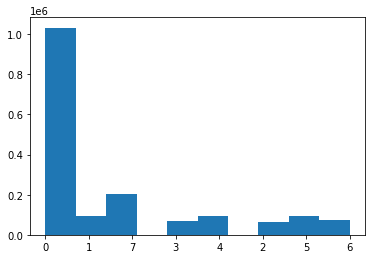

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#plt.hist(pubfile['COST'],bins=[-1000,-500,-100,-10,-5,0,5,10,100,500,1000])
plt.hist(pubfile['CHILDAGE'])


KeyboardInterrupt: 

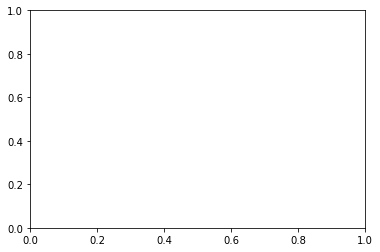

In [81]:
pubfile.CHILDAGE.plot.bar()

In [51]:
#
# Compare to ACS
#
acs = pd.read_csv("D:\\Open Environments\\data\\Open Environments\\blockgroupdemographics\\2019\\2019blockgroupdemographics.csv")

In [53]:
acs.columns

Index(['GEOID', 'B11001e1', 'B11001e2', 'B11001e7', 'B09019e1', 'B09018e1',
       'B19013e1', 'B19001e1', 'B19001e2', 'B19001e3',
       ...
       'MinorityRate', 'PopDensity', 'CollegePlusRate', 'EmploymentRate',
       'FamilyRate', 'ChildrenRate', 'Under25KRate', 'logPop', 'logPopDensity',
       'logLand'],
      dtype='object', length=128)